# 1.0 Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# 2.0 Read CSV
**Nesta etapa, o arquivo csv é lido e atribuido à classe pandas. Também utilizo a função head() para me ajudar a enxergar como os dados estão dispostos, com isso posso gerar ideias de como fazer a próxima etapa.**

In [219]:
dir_path = os.path.dirname(os.path.abspath(''))
csv_path = os.path.join(dir_path,'dataset','teste_indicium_precificacao.csv')
data_frame = pd.read_csv(csv_path)
data_frame.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


# 3.0 Functions
**Todas as funções definidas estão nesta parte do notebook. Assim como suas documentações.**

In [217]:
def outliers_identification(df, coluna):
    """
        função que recebe um data frame e uma coluna no formato string e retorna um dataframe com duas colunas, 
        uma contendo os outliers inferiores e a outra os inferiores.
        args:
            df (Pandas.DataFrame) : data frame contendo a coluna a qual será executada o cálculo de outliers.
            coluna (string): nome da coluna numérica que será operada.
    """
    quartil_1 = df[coluna].quantile(0.25)
    quartil_2 = df[coluna].quantile(0.50)
    quartil_3 = df[coluna].quantile(0.75)
    intervalo_interquartil = quartil_3 - quartil_1
    limite_superior = quartil_3 + 1.5*intervalo_interquartil
    limite_inferior = quartil_1 - 1.5*intervalo_interquartil
    outliers = pd.DataFrame(columns=['inferior_outliers','superior_outliers'])
    outliers['inferior_outliers'] = df[df[coluna] < limite_inferior][coluna]
    outliers['superior_outliers'] = df[df[coluna] > limite_superior][coluna]
    return outliers

def plot_bar_specific(series, xlabel, ylabel, title, **kwargs):
    """
        função que plota um gráfico de barra com características específicas como,
        tamanho da figura, cor de background, grid e rotação dos labels do eixo X.
        args:
            series (Pandas.Series): panda series de onde será tirado as categorias e seus valores, 
            xlabel (string): o nome do eixo X
            ylabel (string): o nome do eixo y
            title (string): título do gráfico 
            **kwargs {
                values (numpy.ndarray): contém valores que não estão presentes na 'series',
                categorias (numpy.ndarray): contém categorias que não estão presentes na 'series'
            }
    """
    if 'values' in kwargs:
        plt.figure(figsize=(8, 3.5), facecolor='lightgrey')
        indices = series.index
        valores = kwargs['values']
        plt.bar(indices, valores, zorder=3, color='purple')
        plt.grid(linestyle='-', zorder=0, alpha=1, color='skyblue')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=25)
        plt.show()
    elif 'categorias' in kwargs:
        plt.figure(figsize=(8, 3.5), facecolor='lightgrey')
        indices = kwargs['categorias']
        valores = series.values
        plt.bar(indices, valores, zorder=3, color='purple')
        plt.grid(linestyle='-', zorder=0, alpha=1, color='skyblue')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=45, fontsize=8)
        plt.show()
    else:
        plt.figure(figsize=(8, 3.5), facecolor='lightgrey')
        indices = series.index
        valores = series.values
        plt.bar(indices, valores, zorder=3, color='purple')
        plt.grid(linestyle='-', zorder=0, alpha=1, color='skyblue')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=25)
        plt.show()

def is_leap_year(year):
    """
        função que retorna True caso o ano seja bissexto e Falso caso contrário.
        args:
            year (int): ano a ser analisado
    """
    if year%4 != 0:
        return False
    elif year%100 == 0 and year%400 != 0:
        return False# 4.0 Data Processing

## Overview

Após uma análise inicial dos dados, é fundamental aprofundar o exame para obter informações mais detalhadas sobre o DataFrame. Essa etapa envolve verificar a quantidade de linhas, identificar valores ausentes e revisar os tipos de dados em cada coluna. Esses insights são cruciais para orientar as próximas etapas de limpeza e preparação dos dados.

## Issues Identified

### 1. Nome das Colunas
As colunas do DataFrame apresentam inconsistências na nomenclatura, com alguns nomes em inglês e outros em português. Essa falta de padronização dificulta o trabalho e a compreensão dos dados. 

### 2. Organização
Dado que a base de dados refere-se a estabelecimentos em Nova York, os nomes das colunas devem ser padronizados para o inglês, garantindo consistência e clareza.

## Next Steps

1. **Padronizar Nomes das Colunas:**
   - Renomear todas as colunas para inglês.
   - Garantir consistência na nomenclatura, utilizando convenções comuns como `snake_case` ou `camelCase`.

2. **Criação de Novas Colunas:**
   - Adicionar colunas derivadas que facilitem as análises futuras. 
   - Por exemplo, calcular métricas auxiliares ou categorizar informações relevantes.

3. **Preparação e Limpeza:**
   - Identificar e lidar com valores ausentes.
   - Confirmar a adequação dos tipos de dados de cada coluna.

Com essas ações, a base de dados estará mais organizada, padronizada e pronta para análises mais detalhadas.
    else:
        return True

def categories_appender(series):
    """
        função que a partir de um Pandas series extrai os index de um MultiIndex e 
        os anexa separando-os por um '-'. 
        *OBS: Essa função é utilizada para os casos de series.index sendo um MultiIndex de 2 índices.*
        args:
            series (Pandas.Series): Pandas series de onde são extraidos os index.
    """
    list_aux = []
    for i in range(len(disponibilidade_por_room_type.index)):
        string_aux0 = str(disponibilidade_por_room_type.index[i][0])
        string_aux1 = str(disponibilidade_por_room_type.index[i][1])
        list_aux.append(string_aux0+'-'+string_aux1)
    aux = np.array(list_aux)
    return aux

def data_processing(df):
    """
        função que prepara a base de dados para a análise. Sua função é padronizar e renomear colunas,
         remover valores vazios do dataset, transformação de dados e criação de outras colunas que auxiliam
         na análise dos dados.
         args:
             df (Pandas.DataFrame): data frame ao qual será realizado todo o processamento de dados.
    """
    # padronização dos nomes das colunas
    # criação de um dict com a troca de nomes das colunas
    colunas_renomeadas = {'nome':'name',
                          'bairro_group':'district',
                          'bairro':'neighborhood',
                          'minimo_noites':'minimum_nights',
                          'numero_de_reviews':'reviews_count',
                          'ultima_review':'last_review',
                          'reviews_por_mes':'monthly_reviews',
                          'calculado_host_listings_count':'calculated_host_listings_count',
                          'disponibilidade_365':'yearly_availability'}
    
    data_frame.rename(columns=colunas_renomeadas, inplace=True)
    
    # eliminação de valores vazios das colunas identificadas
    for coluna in ['name', 'host_name', 'last_review', 'monthly_reviews']:
        df.dropna(subset=[coluna], inplace=True)
    
    # transformar coluna last_review em date time
    df['last_review'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d')
    
    # criação de uma coluna chamada total_price que é o price multiplicado pela quantidade mínima de noites
    df['total_price'] = df.apply(lambda row: row['price']*row['minimum_nights'], axis=1)
    
    # criação da coluna year contendo somente o ano da coluna last_review
    df['year'] = df['last_review'].dt.year
    
    # criação da coluna is_leap_year para checar se o ano é bissexto ou não
    df['is_leap_year'] = df['year'].apply(is_leap_year)
    
    # criação da coluna days booked_days informando quantos dias já foram agendados naquele ano
    df['booked_days'] = df.apply(
                            lambda row: 366 - row['yearly_availability'] if is_leap_year(row['year']) else 365 - row['yearly_availability'],
                            axis = 1
                        )
    return df

# 4.0 Data Processing

## Overview

Após uma análise inicial dos dados, é fundamental aprofundar o exame para obter informações mais detalhadas sobre o DataFrame. Essa etapa envolve verificar a quantidade de linhas, identificar valores ausentes e revisar os tipos de dados em cada coluna. Esses insights são cruciais para orientar as próximas etapas de limpeza e preparação dos dados.

## Problemas Identificados

### 1. Nome das Colunas
1. **Inconcistência**
    - As colunas do DataFrame apresentam inconsistências na nomenclatura, com alguns nomes em inglês e outros em português. Essa falta de padronização dificulta o trabalho e a compreensão dos dados. 

2. **Organização**
    - Dado que a base de dados refere-se a estabelecimentos em Nova York, os nomes das colunas devem ser padronizados para o inglês, garantindo consistência e clareza.

## Próximos Passos

1. **Padronizar Nomes das Colunas:**
   - Renomear todas as colunas para inglês.
   - Garantir consistência na nomenclatura, utilizando convenções comuns como `snake_case` ou `camelCase`.

2. **Criação de Novas Colunas:**
   - Adicionar colunas derivadas que facilitem as análises futuras. 
   - Por exemplo, calcular preço total visto que algumas hospedagens têm número mínimo de noites que devem ser reservadas.

3. **Preparação e Limpeza:**
   - Identificar e eliminar valores ausentes.
   - Modificação dos tipos de dados de cada coluna para seus corretos.

Com essas ações, a base de dados estará mais organizada, padronizada e pronta para análises mais detalhadas.


In [220]:
# print para saber as informações do data frame
print(data_frame.info())

# data frame chamando a função de processamento de dados
data_frame = data_processing(data_frame)

# info do data frame após todos os processos
print(data_frame.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

# 5.0 Análises
**Esta etapa tem como intuito levantamento e validação de hipóteses**

## 5.1 Identificação de Estabelecimentos 'Bons' e seus Outliers

### Definição de Estabelecimentos 'Bons'

Estabelecimentos considerados "bons" são aqueles que possuem baixa disponibilidade anual, o que indica alta procura e agenda lotada, e apresentam uma quantidade significativa de reviews. Nesta etapa, o foco é aprofundar a análise da coluna **`reviews_count`**.

Para evitar o uso de números arbitrários na definição de Estabelecimentos bons, utilizou-se a média como critério:
- Estabelecimentos com disponibilidade **abaixo da média**.
- Estabelecimentos com número de reviews **acima da média**.

### Verificação de Valores Inválidos

Ao verificar o valor mínimo da coluna **`reviews_count`**, é possível identificar possíveis erros na inserção dos dados. 
- **Valores Negativos:** É logicamente inviável que um estabelecimento possua uma quantidade negativa de reviews. Caso tais valores sejam encontrados, providências devem ser tomadas para corrigir ou tratar os dados.
- Para este caso, não foram encontrados valores negativos.

### Outliers

É importante ressaltar que a identificação de outliers não implica necessariamente que os dados devam ser descartados. No contexto da quantidade de reviews, calcular os outliers ajuda a identificar hospedagens com um número muito alto de avaliações. Esses valores, apesar de extremos, são reais e não devem ser desconsiderados.

### Conclusão

A definição de estabelecimentos "bons" e a análise de outliers na coluna **`reviews_count`** fornecem insights importantes para classifica-los e entender melhor o comportamento dos dados. A abordagem evita a exclusão indevida de dados válidos e reforça a qualidade das análises subsequentes.



Quantidade mínima de reviews: 1
Média do número de reviews: 29.29
Média de disponibilidade anual: 114.88
Percentual de outliers superior: 6.20%


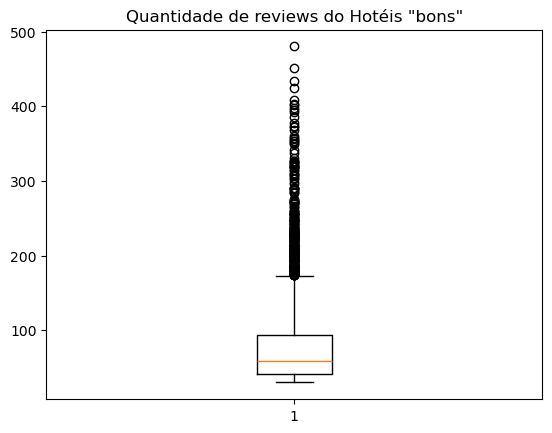

,name,price,minimum_nights,reviews_count,yearly_availability
5,BlissArtsSpace!,60,45,49,0
7,Cozy Clean Guest Room - Family Apt,79,2,118,0
9,Beautiful 1br on Upper West Side,135,5,53,6
10,Central Manhattan/near Broadway,85,2,188,39
14,Only 2 stops to Manhattan studio,140,2,148,46
...,...,...,...,...,...
42664,Queens Studio.,55,2,37,6
42941,Lucio's Room #3 a unos minutos del JFK y LGA,75,1,31,89
43138,Comfortable Room with Private Bath - 15 min to...,50,1,34,61
43790,NYC High End Upper East Side Central Park Gem ...,151,1,30,42


In [224]:
# mínimo e média  da reviews_count. O mínimo aponta se há erro na inserção, caso haja valor negativo.
minimo_numero_reviews = data_frame['reviews_count'].min()
media_numero_reviews = data_frame['reviews_count'].mean()

# média de disponibilidade anual 
media_disponibilidade = data_frame['yearly_availability'].mean()
print(f'Quantidade mínima de reviews: {minimo_numero_reviews}\nMédia do número de reviews: {media_numero_reviews:.2f}\nMédia de disponibilidade anual: {media_disponibilidade:.2f}')

df_disponibilidade_abaixo_media = data_frame[data_frame['yearly_availability'] < media_disponibilidade]

df_lugares_bons_de_alugar = df_disponibilidade_abaixo_media[df_disponibilidade_abaixo_media['reviews_count'] > media_numero_reviews]
df_lugares_bons_de_alugar = df_lugares_bons_de_alugar[['name','price','minimum_nights','reviews_count','yearly_availability']]

# identificando outliers
df = outliers_identification(df_lugares_bons_de_alugar,'reviews_count')
quantidade_de_outliers_superior = df['superior_outliers'].shape[0]
quantidade_total_de_dados = df_lugares_bons_de_alugar['reviews_count'].shape[0]
percentual_de_outliers_superior = (quantidade_de_outliers_superior/quantidade_total_de_dados)*100
print(f'Percentual de outliers superior: {percentual_de_outliers_superior:.2f}%')

plt.boxplot(df_lugares_bons_de_alugar['reviews_count'])
plt.title('Quantidade de reviews do Hotéis "bons"')
plt.show()

df_lugares_bons_de_alugar

# 5.2 Hipóteses e Validações sobre Preços e Distritos

**Hipótese Inicial:**  
Após visualizar os dados deste DataFrame, surgiu-me uma hipótese: os distritos mais populosos de Nova York são os mais baratos para se alugar. Para validar essa ideia, realizei uma breve pesquisa na Internet sobre as populações desses distritos entre os anos de 2011 e 2019. Escolhi essas datas porque a coluna de datas do dataset varia de **2011-03-28** (a menor data) a **2019-07-08** (a maior data).

### População dos Distritos de Nova York (2011–2019)

| Ano   | Manhattan   | Brooklyn    | Queens      | Bronx       | Staten Island |
|-------|-------------|-------------|-------------|-------------|---------------|
| 2011  | 1.605.000   | 2.565.000   | 2.275.000   | 1.395.000   | 470.000       |
| 2012  | 1.630.000   | 2.580.000   | 2.490.000   | 1.496.000   | 475.000       |
| 2013  | 1.635.000   | 2.595.000   | 2.305.000   | 1.415.000   | 480.000       |
| 2014  | 1.650.000   | 2.610.000   | 2.320.000   | 1.425.000   | 485.000       |
| 2015  | 1.465.000   | 2.625.000   | 2.335.000   | 1.453.000   | 490.000       |
| 2016  | 1.680.000   | 2.640.000   | 2.350.000   | 1.445.000   | 495.000       |
| 2017  | 1.695.000   | 2.655.000   | 2.365.000   | 1.455.000   | 500.000       |
| 2018  | 1.710.000   | 2.670.000   | 2.390.000   | 1.465.000   | 505.000       |
| 2019  | 1.725.000   | 2.685.000   | 2.295.000   | 1.475.000   | 510.000       |

**Observação:**  
Apesar das oscilações nas populações ao longo dos anos, um fato persiste: **Brooklyn** é o distrito mais populoso, enquanto **Staten Island** é o menos populoso.

---

## Primeira Validação

**Objetivo:**  
Testar se a hipótese inicial está correta. Para isso, calculei a média dos preços das diárias e agrupei-os por distrito. Em seguida, criei um gráfico de barras com os distritos no eixo X e a média dos preços no eixo Y.

### Média dos Preços por Distrito

| Distrito       | Diária Média  | Ranqueamento |
|----------------|---------------|--------------|
| Bronx          | 79.558857     | 5            |
| Brooklyn       | 121.461613    | 2            |
| Manhattan      | 180.071596    | 1            |
| Queens         | 95.783683     | 3            |
| Staten Island  | 89.964968     | 4            |

**Conclusão:**  
Manhattan é o distrito mais caro, enquanto o Bronx é o mais barato. Portanto, a hipótese inicial estava **incorreta**.

---

## Segunda Hipótese

**Nova Hipótese:**  
O ranqueamento de preços se mantém quando consideramos o "preço real" (preço da diária multiplicado pelo número mínimo de noites necessárias). Para testar essa ideia, recalculei as médias utilizando o preço real.

### Preço Real Médio por Distrito

| Distrito       | Preço Real Médio | Ranqueamento |
|----------------|------------------|--------------|
| Bronx          | 289.017143       | 5            |
| Brooklyn       | 653.465872       | 2            |
| Manhattan      | 1328.286746      | 1            |
| Queens         | 579.924541       | 3            |
| Staten Island  | 311.729299       | 4            |

**Conclusão:**  
Manhattan continua sendo o distrito mais caro, e o Bronx permanece como o mais barato. O ranqueamento **não mudou** em relação à primeira validação.

---

## Análise do Crescimento Percentual

**Objetivo:**  
Calcular o aumento percentual médio do preço real em relação ao preço da diária para cada distrito.

### Crescimento Percentual por Distrito

| Distrito       | Crescimento Percentual (%) | Ranqueamento |
|----------------|----------------------------|--------------|
| Bronx          | 363.274629                 | 4            |
| Brooklyn       | 538.001969                 | 3            |
| Manhattan      | 737.643678                 | 1            |
| Queens         | 605.452328                 | 2            |
| Staten Island  | 346.500761                 | 5            |

**Conclusão Final:**  
Embora Manhattan tenha mantido sua posição como o distrito mais caro, o ranqueamento dos demais distritos mudou. O crescimento percentual revelou que **Manhattan** tem o maior aumento, seguido por **Queens**, **Brooklyn**, **Bronx** e **Staten Island**.

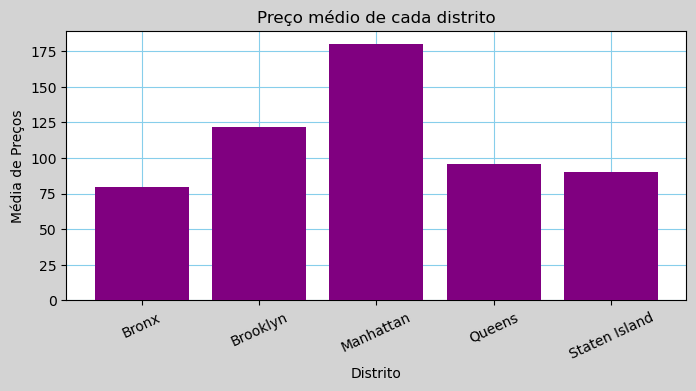

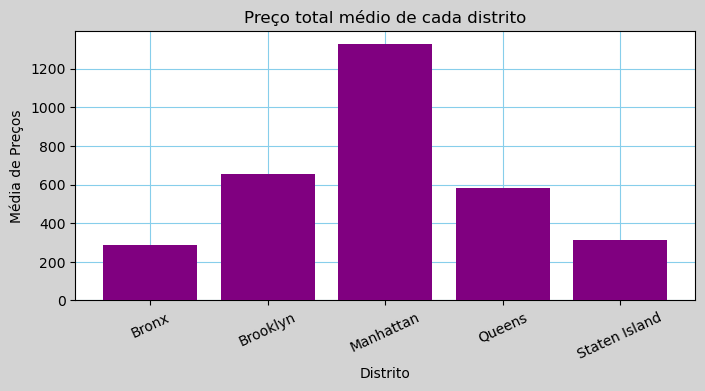

<class 'numpy.ndarray'>


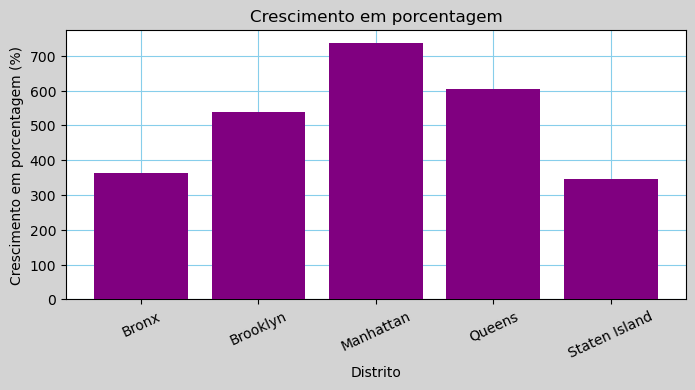

In [208]:
# calcular preço médio da diária e agrupar por distrito
df_preco_medio_por_distrito = data_frame.groupby('district')['price'].mean()

# chamada da função para a plotagem do gráfico de barras com as especificações do canvas
plot_bar_specific(df_preco_medio_por_distrito, 'Distrito', 'Média de Preços', 'Preço médio de cada distrito')

# calcular preço total médio e agrupar por distrito
df_preco_total_medio_por_distrito = data_frame.groupby('district')['total_price'].mean()

# chamada da função para a plotagem do gráfico de barras com as especificações do canvas
plot_bar_specific(df_preco_total_medio_por_distrito, 'Distrito', 'Média de Preços', 'Preço total médio de cada distrito')

# valores das médias armazenadas em arrays para calcular o crescimento percentual entre as duas
medias_por_distrito = df_preco_medio_por_distrito.values
medias_reais_por_distrito = df_preco_total_medio_por_distrito.values

# cálculo do percentual de crescimento preço_total/preço_diaria
for i in range(len(medias_reais_por_distrito)):
    percentual_crescimento = (medias_reais_por_distrito/medias_por_distrito)*100
# chamda da função para o caso específico com a utilização de kwargs
plot_bar_specific(df_preco_total_medio_por_distrito, 'Distrito', 'Crescimento em porcentagem (%)', 'Crescimento em porcentagem', values=percentual_crescimento)

# 5.3 Análise de Disponibilidade e Preço por Tipo de Acomodação e Ano
### Tipos de Acomodação

Existem três tipos principais de acomodação disponíveis:
- **Entire home/apt**: Residência ou apartamento inteiro.
- **Private room**: Quarto privativo.
- **Shared room**: Quarto compartilhado.

### Hipótese

A hipótese inicial é que os quartos compartilhados (**Shared room**) são, em média, os mais disponíveis e baratos para alugar. Essa suposição é baseada na ideia de que compartilhar um cômodo pode ser desconfortável para muitos clientes, tornando esse tipo de acomodação o menos procurado.

### Análise de Dados

- **Disponibilidade:** Por serem menos populares, os cômodos compartilhados devem apresentar maior disponibilidade anual.
- **Preço:** Espera-se que o preço médio dos quartos compartilhados seja menor em comparação com os outros tipos de acomodação.

### Limitação dos Dados

A quantidade de registros relacionados a **Shared room** é significativamente menor do que as categorias **Entire home/apt** e **Private room**. Devido a essa limitação, a análise de faturamento anual será restrita às categorias **Entire home/apt** e **Private room**.

### Conclusão

A análise de preços e disponibilidade para as categorias mais representativas (**Entire home/apt** e **Private room**) fornecerá insights mais robustos e confiáveis sobre o faturamento anual, descartando possíveis vieses causados pela baixa quantidade de dados de **Shared room**.


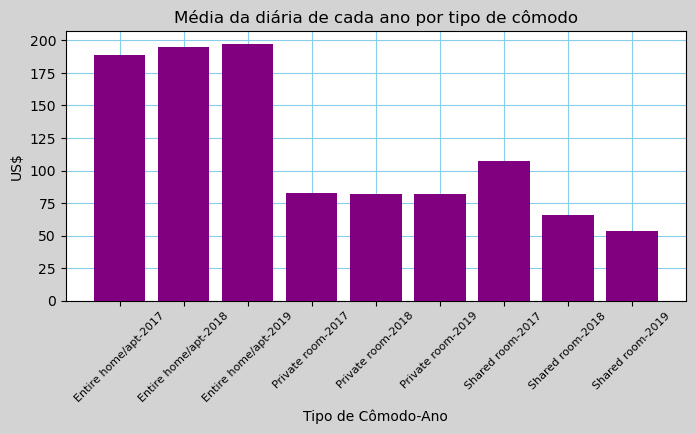

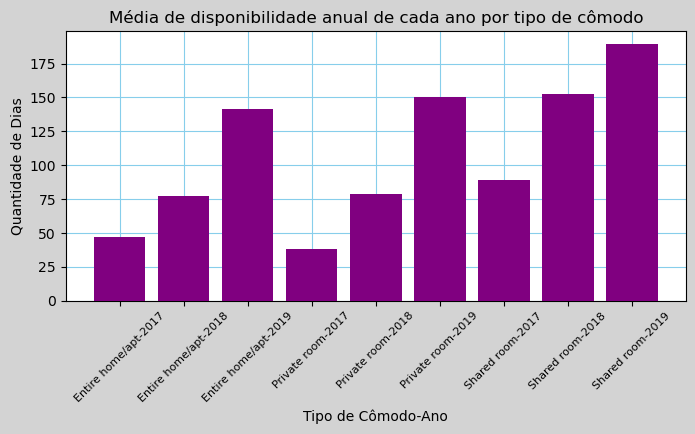

In [226]:
# seleção dos anos acima de 2016 (2017-2019)
df_anos_selecionados = data_frame[data_frame['year'] > 2016]

# data frame contendo média de disponibilidade anual para cada tipo de cômodo e ano
disponibilidade_media_por_room_type = df_anos_selecionados.groupby(['room_type', 'year'])['yearly_availability'].mean()

# data frame contendo média de preço de diária para cada tipo de cômodo e ano
preco_medio_por_room_type = df_anos_selecionados.groupby(['room_type', 'year'])['price'].mean()

# array contendo as categorias concatenadas (room_type-year)
categorias_room_type_by_year = categories_appender(disponibilidade_media_por_room_type)

# chamdas da função utilizando as categorias coletadas acima
plot_bar_specific(preco_medio_por_room_type, 'Tipo de Cômodo-Ano', 'US$', 'Média da diária de cada ano por tipo de cômodo', categorias=categorias_room_type_by_year)
plot_bar_specific(disponibilidade_media_por_room_type, 'Tipo de Cômodo-Ano', 'Quantidade de Dias', 'Média de disponibilidade anual de cada ano por tipo de cômodo', categorias=categorias_room_type_by_year)